## Workflow

1. Check stock splits and transform the data

2. Check the history volatility and truncate the data

### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import BaseLoader
import plotly.express as px
from funcs import to_float, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config
from time import sleep

### Select the data

In [83]:
select_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
df_stock = pd.read_sql(select_query.format(symbol), create_engine(mariadb_string))
df_stock["date"] = pd.to_datetime(df_stock["date"])
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol SBUX: Starbucks
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  TSLA


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787 entries, 0 to 3786
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  3787 non-null   object        
 1   date    3787 non-null   datetime64[ns]
 2   open    3787 non-null   float64       
 3   high    3787 non-null   float64       
 4   low     3787 non-null   float64       
 5   close   3787 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 177.6+ KB


### Check the data

In [34]:
# Check the dates
df_stock.loc[df_stock["date"] > "2015-12-20"].head()

,symbol,date,open,high,low,close
4060,NKE,2015-12-21,129.68,130.31,128.61,129.80
4061,NKE,2015-12-22,131.48,131.85,129.82,131.85
4062,NKE,2015-12-23,136.24,136.39,127.82,128.71
4063,NKE,2015-12-24,64.55,64.73,62.15,63.18
4064,NKE,2015-12-28,63.21,63.88,62.80,63.81


In [86]:
df_stock.head()

,symbol,date,open,high,low,close
0,TSLA,2010-06-29,19.00,25.000,17.54,23.89
1,TSLA,2010-06-30,25.79,30.419,23.30,23.83
2,TSLA,2010-07-01,25.00,25.920,20.27,21.96
3,TSLA,2010-07-02,23.00,23.100,18.71,19.20
4,TSLA,2010-07-06,20.00,20.000,15.83,16.11


In [87]:
df_stock.tail()

,symbol,date,open,high,low,close
3782,TSLA,2025-07-14,317.730,322.599,312.67,316.90
3783,TSLA,2025-07-15,319.675,321.200,310.50,310.78
3784,TSLA,2025-07-16,312.800,323.500,312.62,321.67
3785,TSLA,2025-07-17,323.150,324.340,317.06,319.41
3786,TSLA,2025-07-18,322.190,330.900,321.42,329.65


### Check the chart

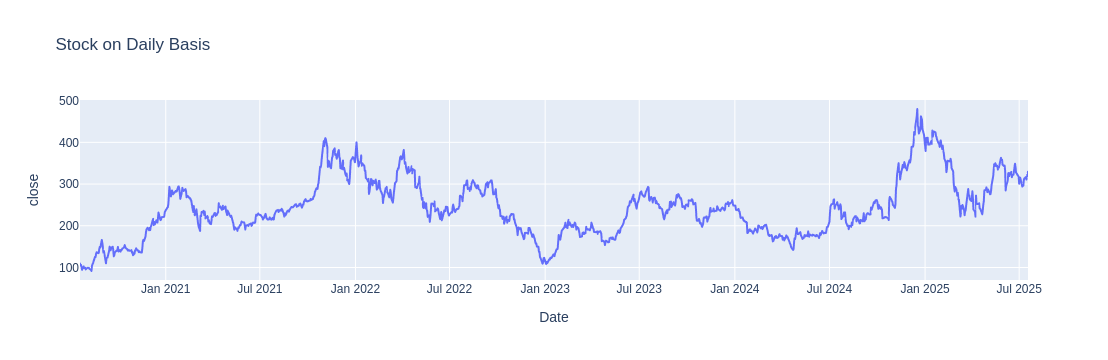

In [98]:
fig = px.line(df_stock, x="date", y="close", title="Stock on Daily Basis", 
              labels={"date": "Date"})

fig.show()

### Adjust stock splits

In [90]:
# Some initial values
try:
    divisor = input("Divisor: ")
    divisor = int(divisor)
except ValueError:
    divisor = float(divisor)
    
split_date = input("Split Date (yyyy-mm-dd): ")
update_query = """UPDATE stock_price SET `open`=`open`/{divisor}, high=`high`/{divisor}, low=`low`/{divisor}, `close`=`close`/{divisor}
where `date` < '{split_date}' and symbol='{symbol}';""".format(divisor=divisor, split_date=split_date, symbol=symbol)
affected_rows = 0

# Make the update
truncate_bool = input("Update the database? (y/n): ")
if truncate_bool in ("y", "Y"):
    affected_rows = loader.query(update_query)
    sleep(1)
    df_stock = pd.read_sql(select_query.format(symbol), create_engine(mariadb_string))
    df_stock["date"] = pd.to_datetime(df_stock["date"])
    
print("\nAffected Rows in database:", affected_rows)
print("Sql Query:", update_query)
print(df_stock.info())

Divisor:  5
Split Date (yyyy-mm-dd):  2020-08-31
Update the database? (y/n):  y



Affected Rows in database: 2561
Sql Query: UPDATE stock_price SET `open`=`open`/5, high=`high`/5, low=`low`/5, `close`=`close`/5
where `date` < '2020-08-31' and symbol='TSLA';
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787 entries, 0 to 3786
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  3787 non-null   object        
 1   date    3787 non-null   datetime64[ns]
 2   open    3787 non-null   float64       
 3   high    3787 non-null   float64       
 4   low     3787 non-null   float64       
 5   close   3787 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 177.6+ KB
None


### The Volatility for the cut off the timeframe 

In [92]:
# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

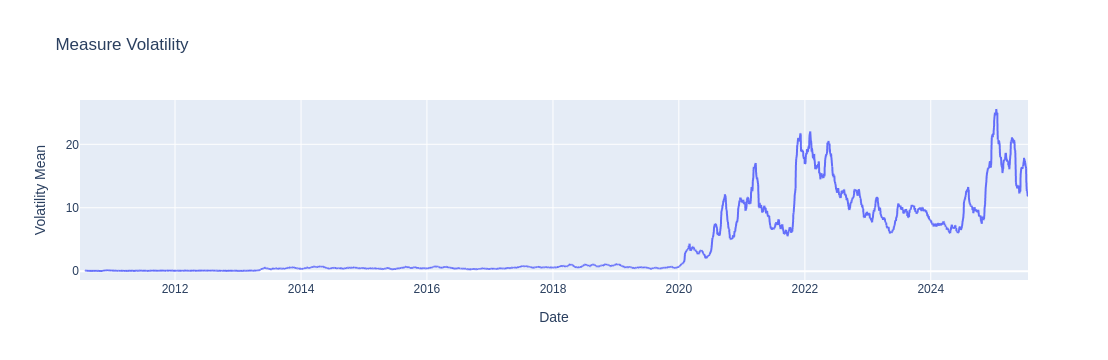

In [93]:
# Show it
fig = px.line(df_stock, x="date", y="volatility_mean", title="Measure Volatility", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

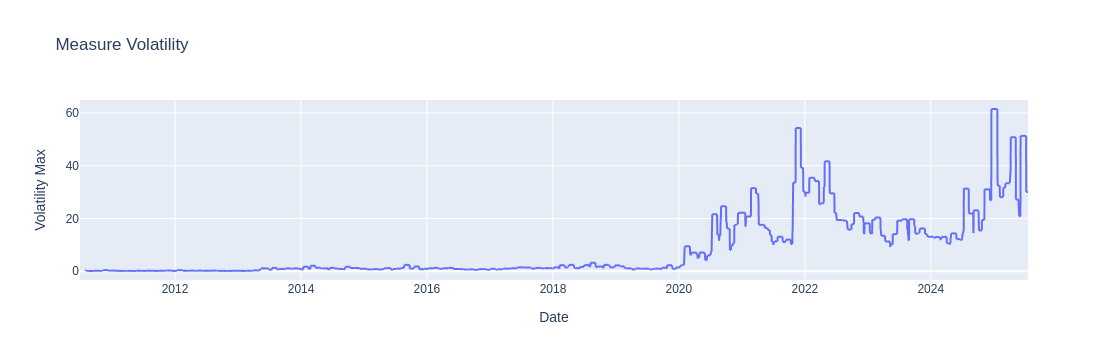

In [96]:
# Show it
fig = px.line(df_stock, x="date", y="volatility_max", title="Measure Volatility", 
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Truncate the timeframe

In [97]:
affected_rows = 0

# Update the database or not
truncate_date = input("Truncate Date (yyyy-mm-dd): ")
delete_string = f"DELETE FROM stock_price WHERE symbol='{symbol}' AND `date`<'{truncate_date}';"
truncate_bool = input("Truncate the database? (y/n): ")

if truncate_bool in ("y", "Y"):
    affected_rows = loader.query(delete_string)
    sleep(1)
    df_stock = pd.read_sql(select_query.format(symbol), create_engine(mariadb_string))
    df_stock["date"] = pd.to_datetime(df_stock["date"])

elif truncate_bool in ("n", "N"):
    df_stock = df_stock.loc[df_stock['date'] >= truncate_date]
    
print(df_stock.head())
print(df_stock.tail())
print(df_stock.info())
print("Affected Rows in database:", affected_rows)

# Hier stehen geblieben

Truncate Date (yyyy-mm-dd):  2020-07-20
Truncate the database? (y/n):  y


  symbol       date     open     high      low    close
0   TSLA 2020-07-20  101.267  110.000   99.200  109.533
1   TSLA 2020-07-21  109.329  111.667  103.867  104.557
2   TSLA 2020-07-22  106.600  108.428  104.133  106.155
3   TSLA 2020-07-23  111.930  112.600   98.718  100.871
4   TSLA 2020-07-24   94.401   97.667   91.103   94.467
     symbol       date     open     high     low   close
1251   TSLA 2025-07-14  317.730  322.599  312.67  316.90
1252   TSLA 2025-07-15  319.675  321.200  310.50  310.78
1253   TSLA 2025-07-16  312.800  323.500  312.62  321.67
1254   TSLA 2025-07-17  323.150  324.340  317.06  319.41
1255   TSLA 2025-07-18  322.190  330.900  321.42  329.65
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  1256 non-null   object        
 1   date    1256 non-null   datetime64[ns]
 2   open    1256 non-null   float64    